In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 13b

## Model with
1. Early stopping
2. ADAM
3. Mini Batch
4. L2 Regularization
5. Swish activation

## FIFA 2019 dataset

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from time import time
import pickle

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

#from scipy.misc import derivative

%matplotlib inline

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 4001 # number of epochs

SAVE_MODEL = False

MIN_LOSS = sys.float_info.max -1 # to save model

LAMBDA = 0.0001 # regularization lambda

###################### Initializing parameters for the ADAM optimiser
#α = 0.001, β_1 = 0.9, β_2 = 0.999 and Adam_epsilon = 10 −8 .
ALPHA = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
ADAM_EPSILON = 1e-8

PATIENCE = 500 # patience level for epochs

BATCH_SIZE = 256 # We want even last batch to be 256

TRAIN_SIZE = int(BATCH_SIZE*64) # to create 64 batches of 256 rows each

modelFilePath = os.path.join(modelDir,subDir, 'fifa_swish_adam_earlystopping_minibatch.pkl')
lossFilePath = os.path.join(modelDir, subDir, 'fifa_swish_adam_earlystopping_minibatch.csv')

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df['test_loss'] == hist_df['test_loss'].min()]
    
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1]['loss'],
                           hist_df.iloc[-1]['test_loss']) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best["test_loss"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_loss"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy()+0.01, best["test_loss"].to_numpy()[0]+0.01), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = 'epoch', y = ['acc', 'test_acc'], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1]['acc'],
                           hist_df.iloc[-1]['test_acc']) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best["test_acc"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]-0.05), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracies')
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [9]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [11]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [12]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [13]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

In [14]:
# one hot encoding
y = pd.get_dummies(y).values
y

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False]])

In [15]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16384, 33) (16384, 4) (1763, 33) (1763, 4)


In [16]:
print (X_test.shape[0] / X_train.shape[0] )

0.10760498046875


In [17]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Prepare model

### Activation and Softmax
<p style="font-family: Arial; font-size:1.2em;">
Softmax code is for demo purpose only. In general softmax functions can be highly unstable.<br>
    <b>Note:</b> If you must implement softmax, use libraries such as scipy.special.softmax.<br><br>
Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
<p>
    
$\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i- max\left ( z \right )}}}$

In [18]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp(z - np.amax(z, axis = 1, keepdims = True))
    # np.amax returns the maximum of an array or maximum along an axis.

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [19]:
# Swish Activation function

def fn_actv(z):
    '''
    Args:
        z: array z value
    Returns:
        a: array - activations
    '''
    
    return z  / (1 + np.exp(-z))

def fn_actv_prime(z):
    '''
    Args:
        z: array
    Returns:
        a: array - activation prime
    '''
    
    return (np.exp(-z) * (z + 1) +1 )/ (1 + np.exp(-z))**2
    #return derivative(fn_actv, z, dx=1e-6)

## Adam Optimizer

In [20]:
def update_m_t_v_t(dW, m_t, v_t, b_1 = BETA_1, b_2 = BETA_2):
    '''
    Adam optimizer function. Note loop is in the main code.
    Args: 
        dW: gradient of weights/bias to be optimised
        m_t : 1st Moment vector of shape same as weights/bias
        v_t : 2nd moment vector of shape same as weights/bias
    Returns:
        updated m_t, vt
    '''
    m_t = b_1 * m_t + ( 1 - b_1 ) * dW           # the moving averages of the gradient
    v_t = b_2 * v_t + ( 1 - b_2 ) * ( dW * dW )  # the moving averages of the squared gradient
    return m_t, v_t

In [21]:
def adam_optimizer( m_t, v_t, t, b_1 = BETA_1,b_2 = BETA_2, alpha = ALPHA, adam_epsilon = ADAM_EPSILON):
    
    '''
    Adam optimizer function. Note loop is in the main code.
    Args:
        m_t : 1st Moment vector of shape same as weights/bias
        v_t : 2nd moment vector of shape same as weights/bias
        t : time step
    Returns:
        updated dW
    '''
    
    t = t + 1 # first epoch t = 0 => for t = 0 both m_cap and v_cap will be infinite
    
    m_cap = m_t/(1-(b_1)**t)                        # the bias-corrected first moment estimate

    v_cap = v_t/(1-(b_2)**t)                        # the bias-corrected second moment estimates
    
    return (alpha * m_cap ) / ( np.sqrt ( v_cap ) + adam_epsilon ) # update dW

In [22]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X_l, y_l, reg_lambda = LAMBDA):
    '''
    Args:
        model: dictionay object containing weights and biases
        X_l: Feature Matrix
        y_l: Labels matrix (One-hot encoding expected)
    Returns:
        Average loss
    '''
    
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    m = X_l.shape[0] # number of samples in X
    
    # Layer 1
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)       # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation
    a2 = fn_softmax(z2)    # Activation
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a2) + (1 - y_l) * np.log(1 - a2) ).sum() 
    
    ################################
    ### Add regularization terms ###
    ################################

    data_loss += reg_lambda/2 * (np.sum(W1**2) + 
                                 np.sum(W2**2))
    
    
    return 1./m * data_loss

In [23]:
# Helper function to predict an output

def predict(model, X_p):
    '''
     Args:
         model: dict object containing weights and biases
         X_p: Feature Matrix
    Returns:
        Predictions against the instances
         
    '''
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']  
    
    # Layer 1
    z1 = X_p.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)       # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2   # Aggregation
    a2 = fn_softmax(z2)    # Activation
   
    return np.argmax(a2, axis = 1)

In [24]:
# Prepare the Model

def build_model(nn_hdim, 
                X : np.ndarray, y : np.ndarray,
                X_t: np.ndarray, y_t: np.ndarray,
                batch_size = 128,
                reg_lambda= LAMBDA,
                epochs = 20000):
    
    '''
    Args:
        nn_hdim    : number of nodes in hidden layer
        X          : Features to train
        y          : Trainig targets (labels)
        X_t        : Features to test
        y_t        : Testing targets (labels)
        batch_size : size of the minibatch
        alpha      : learning rate
        epochs     : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model      : Dictionary object containing weights and biases
    '''
    if os.path.isfile(modelFilePath):
        print (f'Pre-trained model found at {modelFilePath}. Loading....')
        
        with open(modelFilePath, 'rb') as file:
            model_details = pickle.load(file)
            model = model_details['weights']
        print (f'Loaded existing model with\n {model_details["description"]}\n\n')
        print ('#'*50)
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        m_t_w1, v_t_w1 = model['m_t_w1'], model['v_t_w1']
        m_t_b1, v_t_b1 = model['m_t_b1'], model['v_t_b1']
        m_t_w2, v_t_w2 = model['m_t_w2'], model['v_t_w2']
        m_t_b2, v_t_b2 = model['m_t_b2'], model['v_t_b2']
        
    else:
        print (f'No model found at {modelFilePath}. Initializing....')

        nn_input_dim = X_train.shape[1] # input layer dimensionality
        nn_output_dim = y_train.shape[1] # output layer dimensionality

        W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) # as per Lacun Normal
        m_t_w1 = np.zeros_like(W1)  # first Moment Matrix for weights
        v_t_w1 = np.zeros_like(W1)  # second Moment Matrix for weights
        
        
        b1 = np.zeros((1, nn_hdim))
        m_t_b1 = np.zeros_like(b1) # first Moment Matrix for bias
        v_t_b1 = np.zeros_like(b1) # second Moment Matrix for bias
        
        W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
        m_t_w2 = np.zeros_like(W2)  # first Moment Matrix for weights
        v_t_w2 = np.zeros_like(W2)  # second Moment Matrix for weights

        
        b2 = np.zeros((1, nn_output_dim))
        m_t_b2 = np.zeros_like(b2) # first Moment Matrix for bias
        v_t_b2 = np.zeros_like(b2) # second Moment Matrix for bias
    
    
    startTime = time()
    
    curr_loss = 0
    ct_loss = 0.
    epoch, loss, t_loss, acc, t_acc = [], [], [], [], []
    
    
    since_last_save = 0
    min_loss = MIN_LOSS
    num_batches =  int(X.shape[0] / batch_size)
    
    for i in range(0, epochs):
        
        epochTime = time()
        
        for batch in range (num_batches):
            
            batch_start = batch * batch_size
            batch_end   = (batch +1) * batch_size
            
            if batch_end >= X.shape[0]:
                batch_end  = X.shape[0] - 1
                
            a0 = X[batch_start : batch_end, : ]
            y0 = y[batch_start : batch_end]
                
            m = a0.shape[0] # training set size
        
            #### Forward ------------------------------
            # Layer 1
            z1 = a0.dot(W1) + b1 
            a1 = fn_actv(z1)    # activation

            # Layer 2
            z2 = a1.dot(W2) + b2 
            a2 = fn_softmax(z2)    # activation


            ### Back Prop ------------------------------
            #Layer 2
            dz2 = a2- y0

            dW2 = (a1.T).dot(dz2)  
            assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)

            db2 = np.sum(dz2, axis=0, keepdims=True)
            assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)

            da1= dz2.dot(W2.T)

            #Layer 1
            dz1 = da1 * fn_actv_prime(a1)
            dW1 = (a0.T).dot(dz1)
            assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)

            db1 = np.sum(dz1, axis=0, keepdims=True)
            assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
            
            ######################
            ### L2 Regularizer ###
            ######################
            # b1 and b2 don't have regularization terms
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1
            
            t = i*batch_size + batch
 
            # ADAM Optimizer
            m_t_w1, v_t_w1 = update_m_t_v_t(dW1, m_t_w1, v_t_w1)
            W1 += -adam_optimizer(m_t_w1, v_t_w1, t) / m
            
            m_t_w2, v_t_w2 = update_m_t_v_t(dW2, m_t_w2, v_t_w2)
            W2 += -adam_optimizer(m_t_w2, v_t_w2, t) / m

            m_t_b1, v_t_b1 = update_m_t_v_t(db1, m_t_b1, v_t_b1)
            b1 += -adam_optimizer(m_t_b1, v_t_b1, t) / m

            m_t_b2, v_t_b2 = update_m_t_v_t(db2, m_t_b2, v_t_b2)
            b2 += -adam_optimizer(m_t_b2, v_t_b2, t) / m
        
        
            model = {'W1': W1, 'm_t_w1': m_t_w1, 'v_t_w1': v_t_w1,
                     'b1': b1, 'm_t_b1': m_t_b1, 'v_t_b1': v_t_b1,
                     'W2': W2, 'm_t_w2': m_t_w2, 'v_t_w2': v_t_w2,
                     'b2': b2, 'm_t_b2': m_t_b2, 'v_t_b2': v_t_b2}
        
        
        
        if i % 10 == 0:
            
            # Keep count of epoch
            epoch.append(i)
            
            # Calculate loss
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            
            ct_loss = calculate_loss ( model, X_t, y_t)
            t_loss.append(ct_loss)
            
            # Calculate accuracy
            y_pred = predict(model, X)
            curr_acc = accuracy_score(np.argmax(y, axis = 1), y_pred )
            acc.append(curr_acc)
            
            yt_pred = predict(model, X_t)
            currt_acc = accuracy_score(np.argmax(y_t, axis = 1), yt_pred )
            t_acc.append(currt_acc)
            
            #####################################
            ### Save model with min test loss ###
            #####################################
            if ct_loss < min_loss:
                min_loss = ct_loss
                model_save = model.copy()
                save_epoch = i
                since_last_save = 0  # reset counter once model is saved 

                if since_last_save > PATIENCE:
                    print ('Saving model at epoch {}, Loss : {:.4f}, Test Loss : {:.4f}'.format(save_epoch,curr_loss, ct_loss))
                    break
            
        since_last_save +=1 
    
        # Print the loss.
        if i % 500 == 0:
            print(f'Epoch # :{i}', end =' ')
            print(f'Time | Till now: {(time() - startTime ) / 60.:0.2f} mins', end =' ')
            print(f'Last epoch: {(time() - epochTime):0.2f}s', end =' ')
            print(f'Loss| Train: {curr_loss :.4f}', end =' ')
            print(f'Test: {ct_loss :.4f}', end =' ') 
            print(f'Acc| Train: {curr_acc: .4f}', end =' ')
            print (f'Test: {currt_acc :.4f}')
            print("-" *50)
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    loss_hist['acc'] = acc
    loss_hist['test_acc'] = t_acc
    
    # Return model with minimum test loss
    return model_save

In [25]:
nn_hidden_dim = 18

In [26]:
loss_hist = {}

model = build_model(nn_hidden_dim, X_train, y_train, X_test, y_test, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS) 


No model found at ../models/fifa_2019/fifa_swish_adam_earlystopping_minibatch.pkl. Initializing....
Epoch # :0 Time | Till now: 0.00mins Last epoch: 0.08s Loss| Train: 2.2302 Test: 2.2302 Acc| Train:  0.3649 Test: 0.3500
--------------------------------------------------
Epoch # :500 Time | Till now: 0.49mins Last epoch: 0.09s Loss| Train: 0.5872 Test: 0.5846 Acc| Train:  0.8785 Test: 0.8735
--------------------------------------------------
Epoch # :1000 Time | Till now: 1.01mins Last epoch: 0.09s Loss| Train: 0.5634 Test: 0.5611 Acc| Train:  0.8829 Test: 0.8809
--------------------------------------------------
Epoch # :1500 Time | Till now: 1.53mins Last epoch: 0.09s Loss| Train: 0.5542 Test: 0.5547 Acc| Train:  0.8848 Test: 0.8843
--------------------------------------------------
Epoch # :2000 Time | Till now: 2.06mins Last epoch: 0.09s Loss| Train: 0.5486 Test: 0.5526 Acc| Train:  0.8854 Test: 0.8832
--------------------------------------------------
Epoch # :2500 Time | Till now

In [27]:
loss_df = pd.DataFrame(loss_hist)

In [28]:
model_details = {}

model_details['description'] = f'''Hidden layers : 1;
Layer sizes: as per input and output features
    Input-{model['W1'].shape[0]}; Hidden-{nn_hidden_dim},Output-{model['b2'].shape[0]}'''

model_details['weights'] = model

if SAVE_MODEL:
    
    with open(modelFilePath, 'wb') as file:
        pickle.dump(model_details, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    loss_df.to_csv(lossFilePath)

In [29]:
#model

In [30]:
model.keys()

dict_keys(['W1', 'm_t_w1', 'v_t_w1', 'b1', 'm_t_b1', 'v_t_b1', 'W2', 'm_t_w2', 'v_t_w2', 'b2', 'm_t_b2', 'v_t_b2'])

In [31]:
#model['v_t_w1']

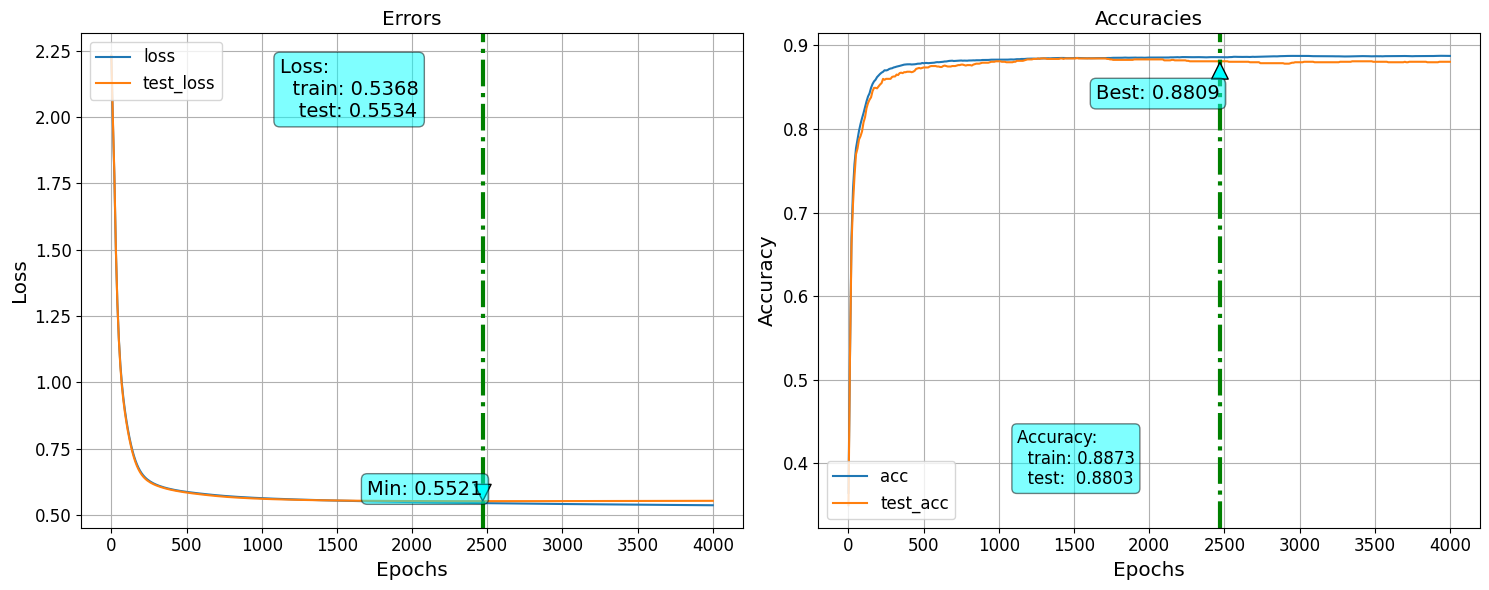

In [32]:
plot_hist(loss_df)

In [33]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
247,2470,0.544788,0.55215,0.885803,0.880885


In [34]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :{:.5f}'.format( accuracy_score(np.argmax(y_train, axis = 1), y_pred ) ) )

Accuracy score on Train Data :0.88733


In [35]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       0.92      0.93      0.93      5296
           2       0.84      0.87      0.86      6174
           3       0.86      0.78      0.82      3086

    accuracy                           0.89     16384
   macro avg       0.91      0.89      0.90     16384
weighted avg       0.89      0.89      0.89     16384



In [36]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), y_pred)))

Accuracy score on Test Data :0.88032


In [37]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       0.92      0.93      0.93       570
           2       0.82      0.87      0.85       664
           3       0.86      0.74      0.79       332

    accuracy                           0.88      1763
   macro avg       0.90      0.89      0.89      1763
weighted avg       0.88      0.88      0.88      1763



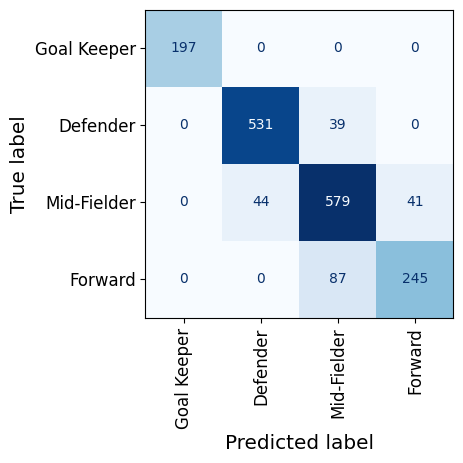

In [38]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();